In [146]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
import os
from PIL import Image

In [147]:
class GenderDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        self.image_paths = []
        self.labels = []

        for idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                self.image_paths.append(os.path.join(class_dir, img_name))
                self.labels.append(idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [148]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets

train_dataset = GenderDataset(root_dir="C:/Users/SIDDHESHWAR DUBEY/Downloads/Gender_data/Training", transform=train_transform)
val_dataset = GenderDataset(root_dir="C:/Users/SIDDHESHWAR DUBEY/Downloads/Gender_data/Validation", transform=val_transform)

In [149]:
print(f"Class names: {train_dataset.classes}")
print(f"Class-to-index mapping: {train_dataset.class_to_idx}")

Class names: ['female', 'male']
Class-to-index mapping: {'female': 0, 'male': 1}


In [150]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [151]:
for images, labels in train_loader:
    print(f"Images shape: {images.shape}")
    print(f"Labels: {labels}")
    break

Images shape: torch.Size([32, 3, 224, 224])
Labels: tensor([1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
        0, 0, 1, 0, 1, 1, 1, 1])


In [152]:
class GenderCNN(nn.Module):
    def __init__(self):
        super(GenderCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, 2)  # 2 classes: male and female
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 56 * 56)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [153]:
model = GenderCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [154]:
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")

model.to(device)


Using device: cuda
GPU: NVIDIA GeForce RTX 3050 6GB Laptop GPU


GenderCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=200704, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [155]:
import torch
from tqdm import tqdm
import time

num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")

model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_loss = torch.tensor(0.0, device=device)
    start_time = time.time()

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

    for batch_idx, (images, labels) in enumerate(progress_bar):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss  

        # Update progress bar with current loss
        progress_bar.set_postfix(loss=loss.item())  

    epoch_time = time.time() - start_time
    avg_loss = running_loss / len(train_loader)  

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss.item():.4f} - Time: {epoch_time:.2f}s")


Using device: cuda
GPU: NVIDIA GeForce RTX 3050 6GB Laptop GPU


Epoch [1/10] - Loss: 0.3796 - Time: 2287.26s


Epoch [2/10] - Loss: 0.2098 - Time: 2302.53s


Epoch [3/10] - Loss: 0.1696 - Time: 2022.92s


Epoch [4/10] - Loss: 0.1472 - Time: 1963.64s


Epoch [5/10] - Loss: 0.1282 - Time: 1962.18s


Epoch [6/10] - Loss: 0.1125 - Time: 2102.28s


Epoch [7/10] - Loss: 0.1007 - Time: 2422.79s


Epoch [8/10] - Loss: 0.0906 - Time: 2319.72s


Epoch [9/10] - Loss: 0.0783 - Time: 2202.53s


Epoch [10/10] - Loss: 0.0697 - Time: 2545.42s


In [156]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Validation Accuracy: {100 * correct / total:.2f}%")

Validation Accuracy: 95.10%


In [157]:
torch.save(model.state_dict(), "gender_detection_model.pth")
model.load_state_dict(torch.load("gender_detection_model.pth"))
model.eval()

C:\Users\SIDDHESHWAR DUBEY\AppData\Local\Temp\ipykernel_24700\666221085.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("gender_detectio

GenderCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=200704, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [159]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [160]:
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = test_transform(image).unsqueeze(0)  # Add batch dimension
    return image.to(device)

In [168]:
def predict_gender(image_path):
    image = load_image(image_path)
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        return "Female" if predicted.item() == 0 else "Male"

# Example usage
image_path = "C:/Users/SIDDHESHWAR DUBEY/Downloads/Gender_data/Validation/female/131220.jpg.jpg"
prediction = predict_gender(image_path)
print(f"Predicted Gender: {prediction}")

Predicted Gender: Female


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0182073..2.2489083].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9831933..2.2739873].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8956583..2.3262744].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.2489083].


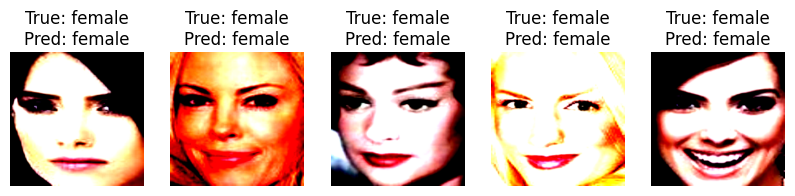

In [169]:
import matplotlib.pyplot as plt

def visualize_predictions(loader, model, num_images=5):
    model.eval()
    images, labels = next(iter(loader))
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    images = images.cpu()
    labels = labels.cpu()
    predicted = predicted.cpu()

    class_names = train_dataset.classes

    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))
        plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[predicted[i]]}")
        plt.axis("off")
    plt.show()

visualize_predictions(val_loader, model)

In [170]:
import os
from PIL import Image

test_folder = "C:/Users/SIDDHESHWAR DUBEY/Downloads/Gender_data/Validation/male"
image_paths = [os.path.join(test_folder, img_name) for img_name in os.listdir(test_folder)]

In [172]:
def predict_gender(image_path):
    image = Image.open(image_path).convert("RGB")
    image = test_transform(image).unsqueeze(0).to(device)  # Add batch dimension
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        return "Female" if predicted.item() == 0 else "Male"

# Predict for all images in the folder
predictions = []
for img_path in image_paths:
    prediction = predict_gender(img_path)
    predictions.append((img_path, prediction))
    print(f"Image: {os.path.basename(img_path)}, Predicted Gender: {prediction}")

Image: 063429.jpg.jpg, Predicted Gender: Male
Image: 063430.jpg.jpg, Predicted Gender: Male
Image: 063438.jpg.jpg, Predicted Gender: Male
Image: 063443.jpg.jpg, Predicted Gender: Male
Image: 063453.jpg.jpg, Predicted Gender: Male
Image: 063460.jpg.jpg, Predicted Gender: Male
Image: 063474.jpg.jpg, Predicted Gender: Male
Image: 063477.jpg.jpg, Predicted Gender: Male
Image: 063478.jpg.jpg, Predicted Gender: Male
Image: 063479.jpg.jpg, Predicted Gender: Male
Image: 063489.jpg.jpg, Predicted Gender: Male
Image: 063491.jpg.jpg, Predicted Gender: Male
Image: 063495.jpg.jpg, Predicted Gender: Male
Image: 063496.jpg.jpg, Predicted Gender: Female
Image: 063500.jpg.jpg, Predicted Gender: Male
Image: 063503.jpg.jpg, Predicted Gender: Male
Image: 063508.jpg.jpg, Predicted Gender: Male
Image: 063513.jpg.jpg, Predicted Gender: Male
Image: 063515.jpg.jpg, Predicted Gender: Male
Image: 063517.jpg.jpg, Predicted Gender: Male
Image: 063518.jpg.jpg, Predicted Gender: Male
Image: 063520.jpg.jpg, Predicted

KeyboardInterrupt: 